## Importing the Libraries

In [3]:
import tensorflow as tf
import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

## Preprocessing the Dataset

In [2]:
# Processing Promoters
df = pd.read_csv("PromoterSequence.txt",sep = '>')
df.dropna(subset=['Unnamed: 0'], how='all', inplace = True)
df.reset_index(inplace = True)
df.drop(['index','EP 1 (+) mt:CoI_1; range -100 to 200.'],axis = 1, inplace = True)
df.rename(columns={'Unnamed: 0': "Sequence"},inplace = True)
df['label'] = 0
display(df.head())
display(df.shape)

,Sequence,label
0,TTAATTTGTCCTTATTTGATTAAGAAGAATAAATCTTATATATAGA...,0
1,ATAGCTCAAATTGCTTTATTAGTATTAGAATCAGCTGTAGCTATAA...,0
2,AAGCTTCCCTTTAATGTGCTCCTTGTGAATACAGCATTACAATGCC...,0
3,TATGTAGAATCTGTACAAGTATCTGTGTTTGGACAATGGCATGTGT...,0
4,ACATATTACTGCATACAGGTCTCAAATTATAAAATGACACTCGTGG...,0


(11300, 2)

In [3]:
# Processing Non Promoters
df2 = pd.read_csv("NonPromoterSequence.txt",sep = '>')
df2.dropna(subset=['Unnamed: 0'], how='all', inplace = True)
df2.reset_index(inplace = True)
df2.drop(['index','EP 1 (+) mt:CoI_1; range -400 to -100.'],axis = 1, inplace = True)
df2.rename(columns={'Unnamed: 0': "Sequence"},inplace = True)
df2['label'] = 1
display(df2.head())
display(df2.shape)

,Sequence,label
0,TAATTACATTATTTTTTTATTTACGAATTTGTTATTCCGCTTTTAT...,1
1,ATTTTTACAAGAACAAGACATTTAACTTTAACTTTATCTTTAGCTT...,1
2,AGAGATAGGTGGGTCTGTAACACTCGAATCAAAAACAATATTAAGA...,1
3,TATGTATATAGAGATAGGCGTTGCCAATAACTTTTGCGTTTTTTGC...,1
4,AGAAATAATAGCTAGAGCAAAAAACAGCTTAGAACGGCTGATGCTC...,1


(11300, 2)

In [4]:
df = pd.concat([df, df2], axis = 0 )
df.shape

(22600, 2)

In [5]:
for seq in df['Sequence']:
    if 'N' in seq:
        display(df.loc[df['Sequence'] == seq])

,Sequence,label
1822,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGAATTC...,1


In [6]:
df.drop([1822], inplace = True)

In [7]:
for seq in df['Sequence']:
    if 'N' in seq:
        display(df.loc[df['Sequence'] == seq])

In [8]:
sequence = list(df.loc[:, 'Sequence'])
encoded_list = []

In [9]:
def encode_seq(seq):
    Encode = {'A' : [1,0,0,0], 'T' : [0,1,0,0], 'G' : [0,0,1,0], 'C' : [0,0,0,1]}
    return [Encode[i] for i in seq]  

In [10]:
for seq in df['Sequence']:
    x = encode_seq(seq)
    encoded_list.append(x)

X = np.array(encoded_list)
print(X.shape) 

(22598, 301, 4)


In [11]:
y = df['label']
y.shape

(22598,)

## Spliting Datasets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [13]:
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

## Training Model

In [4]:
cnn_model = Sequential()

cnn_model.add(Conv1D(filters = 128, kernel_size = 3, activation = 'relu', input_shape = (301, 4)))
cnn_model.add(MaxPooling1D(pool_size= 2))
cnn_model.add(Dropout(0.4))

cnn_model.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling1D(pool_size= 2))
cnn_model.add(Dropout(0.4))

cnn_model.add(Conv1D(filters = 32, kernel_size = 2, activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling1D(pool_size= 2))
cnn_model.add(Dropout(0.4))


cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation = 'relu'))
cnn_model.add(Dense(64, activation = 'relu'))
cnn_model.add(Dense(32, activation = 'relu'))
cnn_model.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
cnn_model.add(Dense(2, activation = 'sigmoid'))

/Users/shantanufuke/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 299, 128)       │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 149, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 149, 64)        │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 74, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 74, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 74, 32)         │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,818 (721.95 KB)

 Trainable params: 184,818 (721.95 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [47]:
early_stoping_callback    = EarlyStopping(monitor = 'val_accuracy', patience=15, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(filepath = "best_model.keras", monitor = 'val_accuracy', save_best_only = True, mode ='max')
epochs = 50
history = cnn_model.fit(X_train, y_train, 
                        batch_size = 128, 
                        validation_data = (X_test, y_test), 
                        epochs=epochs,
                        callbacks = [early_stoping_callback, model_checkpoint_callback]
                       )

Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.5787 - loss: 0.8097 - val_accuracy: 0.7628 - val_loss: 0.5623
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7527 - loss: 0.5575 - val_accuracy: 0.7837 - val_loss: 0.4894
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7830 - loss: 0.4810 - val_accuracy: 0.8014 - val_loss: 0.4503
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7939 - loss: 0.4498 - val_accuracy: 0.8319 - val_loss: 0.3967
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.8161 - loss: 0.4111 - val_accuracy: 0.8430 - val_loss: 0.3785
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8218 - loss: 0.3975 - val_accuracy: 0.8540 - val_loss: 0.3612
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8375 - loss: 0.3720 - val_accuracy: 0.8572 - val_loss: 0.3427
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8430 - loss: 0.3602 - 

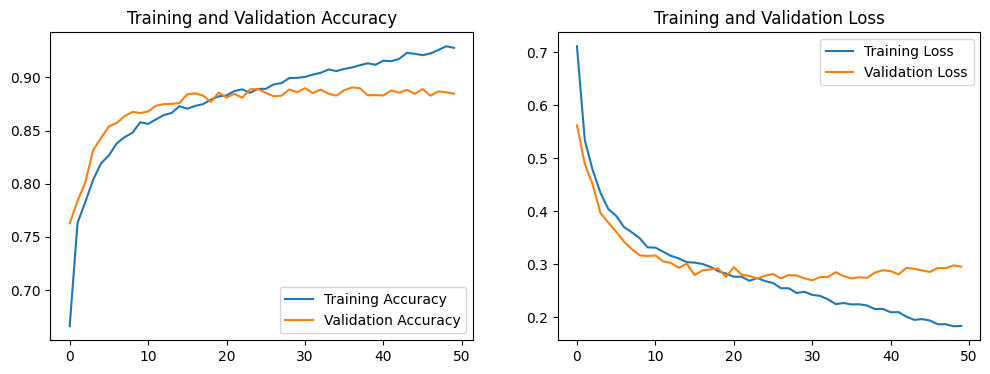

In [49]:
# Plot model accuracy and loss
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8902 - loss: 0.2788
Test Loss: 0.27553126215934753
Test Accuracy: 0.8906194567680359
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2825
           1       0.87      0.92      0.89      2825

    accuracy                           0.89      5650
   macro avg       0.89      0.89      0.89      5650
weighted avg       0.89      0.89      0.89      5650

Confusion Matrix


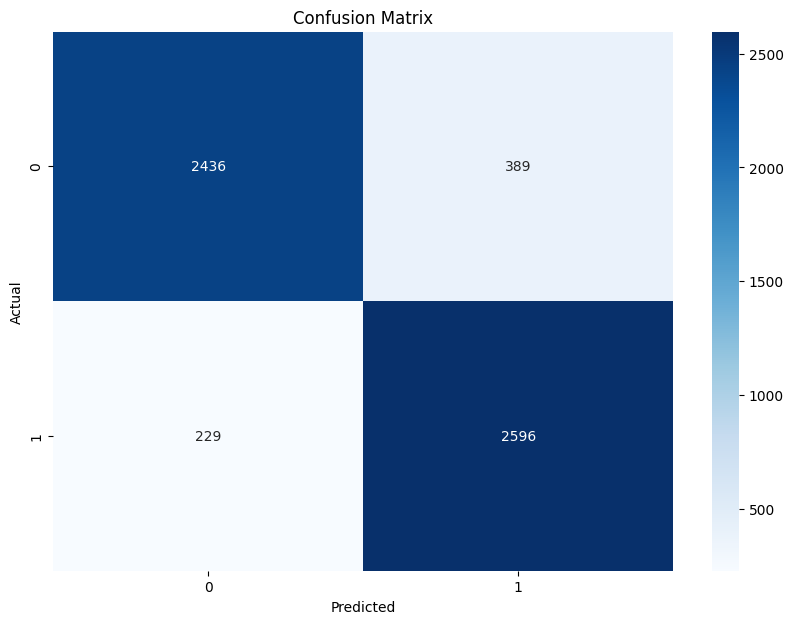

In [50]:
# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification report and confusion matrix
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

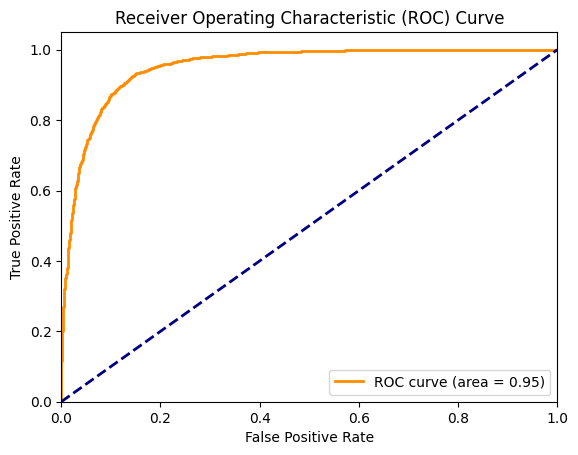

In [51]:
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()